In [17]:
import pandas as pd
df = pd.read_csv('./train.csv')
print("\n\nMETADATA")
print("--------------------")

print(f"\n{len(df.index)} samples")
print(f"{len(df.columns)} columns")

print(f"\nnull count: \n{df.isnull().sum()}")

class_values = df.label.unique()
class_values.sort()
print(f"\nclasses:\n{class_values}")
print(df['label'].value_counts())


sum = 0
avg = 0
for i in class_values:
    sum+=len(df[df['label'] == i].index)
avg = sum/len(class_values)
print(f"\nAverage class distribution: {avg}")

class_distribution = df.groupby("label").size()
print(f"\nclass distribution:\n{class_distribution}")


print(df.head())




METADATA
--------------------

50000 samples
2 columns

null count: 
im_name    0
label      0
dtype: int64

classes:
[0 1 2 3 4 5 6 7 8 9]
label
2    5038
8    5020
1    5012
0    5010
3    5007
7    5000
4    4995
5    4993
9    4970
6    4955
Name: count, dtype: int64

Average class distribution: 5000.0

class distribution:
label
0    5010
1    5012
2    5038
3    5007
4    4995
5    4993
6    4955
7    5000
8    5020
9    4970
dtype: int64
       im_name  label
0  00016cd.jpg      6
1  0001808.jpg      2
2  0002399.jpg      1
3  0003973.jpg      3
4  00061cc.jpg      4


Comments on dataframe:

- The dataset is considered a large dataset. 50,000 samples is a lot.
- the dataset is clean. No need to interpolate missing values or remove columns/rows.
- the class distribution is very even. 
- there are 10 labels. Multiclass.


In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import numpy as np
import math 

mpl.rcParams["figure.dpi"] = 150

first_sample = df.iloc[[0]]
print(f"FIRST SAMPLE:\n{first_sample}")
sample_image_name = first_sample.im_name.values[0]
image_path = f"./train_ims/{sample_image_name}"
im = Image.open(image_path)
pixels = np.array(list(im.getdata()))
im.close()
height = int(math.pow(len(pixels), 1/2))
width = height
print(f"\n\ndata dimension:\nheight: {int(height)}\nwidth: {int(width)}\nfeatures: {len(pixels)}\n\n")
print(pixels)



FIRST SAMPLE:
       im_name  label
0  00016cd.jpg      6


data dimension:
height: 32
width: 32
features: 1024


[[237 242 246]
 [238 246 249]
 [228 239 241]
 ...
 [112 150 153]
 [104 144 135]
 [ 96 139 122]]


Comments on data:
- number of features is very large.
- each feature has a RGB value. How do we convert RGB into a single value?
- can't split image into 3 colour groups, R, G, B. The relationships between different colours would be lost.
- images of the same class vary a lot. High variance within image classes.
- for instance, different angles, different colours, different distances from camera.



Initial Ideas:

Large dataset.
-> use smaller K in K-fold validation to improve training performance. 
-> Perhaps k = 5

Even class distribution:
-> no need to apply any class balancing techniques, such as penalty weighting.

Multiclass:
-> will need an ensemble of SVMs. A SVM for each class in a ensemble.

Features:
-> should NOT use feature selection. Features are heavily related to one another and the variance in images is too great.
-> feature reduction may be an idea, but the images are already so low resolution. Further compressing them may cause it to lose detail



model ideas:

- use an ensemble of HOG and colour SVMS
- OVA SVMS for each class.
- 10 grayscale HOG SVM classifers to determine a class based on image structure
- 10 colour SVM classifiers to determin a class based on colour structure
- together in one Ensemble

- augmentation ideas
- https://datamonje.com/image-data-augmentation/
- before any model training. pre-pre-procession.
- create the augmented images and name tham systematically. Put them in a different folder
- make a horiziontal flip image, a lighting transforms (randomised hue, saturation, contrast values) image, and a shear (stretch persepctive, etc)
- after all of this, duplicate everything and grayscale it.

- in end
- train_img (unaffected)
- train_GS_img
- train_aug_img
- train_GS_aus_img

come up with some naming system

BUILD A AUGMENTATION PIPELINE, copy something from internet.


- using data
- only use augmented data in training set. NOT IN VALIDATION OR TEST
- how?
- when training and going through each image name, load the augmented images by modifying the image name.
- i.e. img1234.jpg -> img1234_flip.jpg
- do a grid search to systemtically get all augmentations of that image.

- use nested-kfold.
- make sure only the inner trianing data uses augmented data.




00016cd.jpg
0001808.jpg
0002399.jpg
0003973.jpg
00061cc.jpg
0007365.jpg
0007d24.jpg
0009157.jpg
000a239.jpg
000a477.jpg
000dde3.jpg
000e993.jpg
000edf2.jpg
000ff7b.jpg
00107cf.jpg
0016c39.jpg
0016e7f.jpg
00170f0.jpg
0018991.jpg
0019531.jpg
001ab02.jpg
001adfd.jpg
001b3ac.jpg
001bb0e.jpg
001e6f1.jpg
00228b0.jpg
0023eda.jpg
00253a0.jpg
00292ef.jpg
0029b8f.jpg
002b5c8.jpg
002b66d.jpg
002cd0a.jpg
002e96a.jpg
002ecbf.jpg
003118b.jpg
003518c.jpg
003686e.jpg
0037e1f.jpg
0038889.jpg
0039f84.jpg
003a294.jpg
003a894.jpg
003adab.jpg
003d4bb.jpg
003e8ac.jpg
003eb9e.jpg
0040cf6.jpg
0041444.jpg
00433dd.jpg
0044e44.jpg
0044e9c.jpg
004547b.jpg
004612c.jpg
00463f5.jpg
00472fe.jpg
0048e10.jpg
0049e4b.jpg
004a017.jpg
004cb37.jpg
004ce59.jpg
004e43f.jpg
004f0ef.jpg
004f3f9.jpg
00505d0.jpg
0051b4a.jpg
0052a41.jpg
0053322.jpg
0054e86.jpg
00555d8.jpg
00556f5.jpg
0055ef4.jpg
0055f16.jpg
00575c6.jpg
005f68b.jpg
0060fec.jpg
0061a6d.jpg
0063fb3.jpg
00642ce.jpg
006454a.jpg
006576f.jpg
0066b24.jpg
006880c.jpg
0068

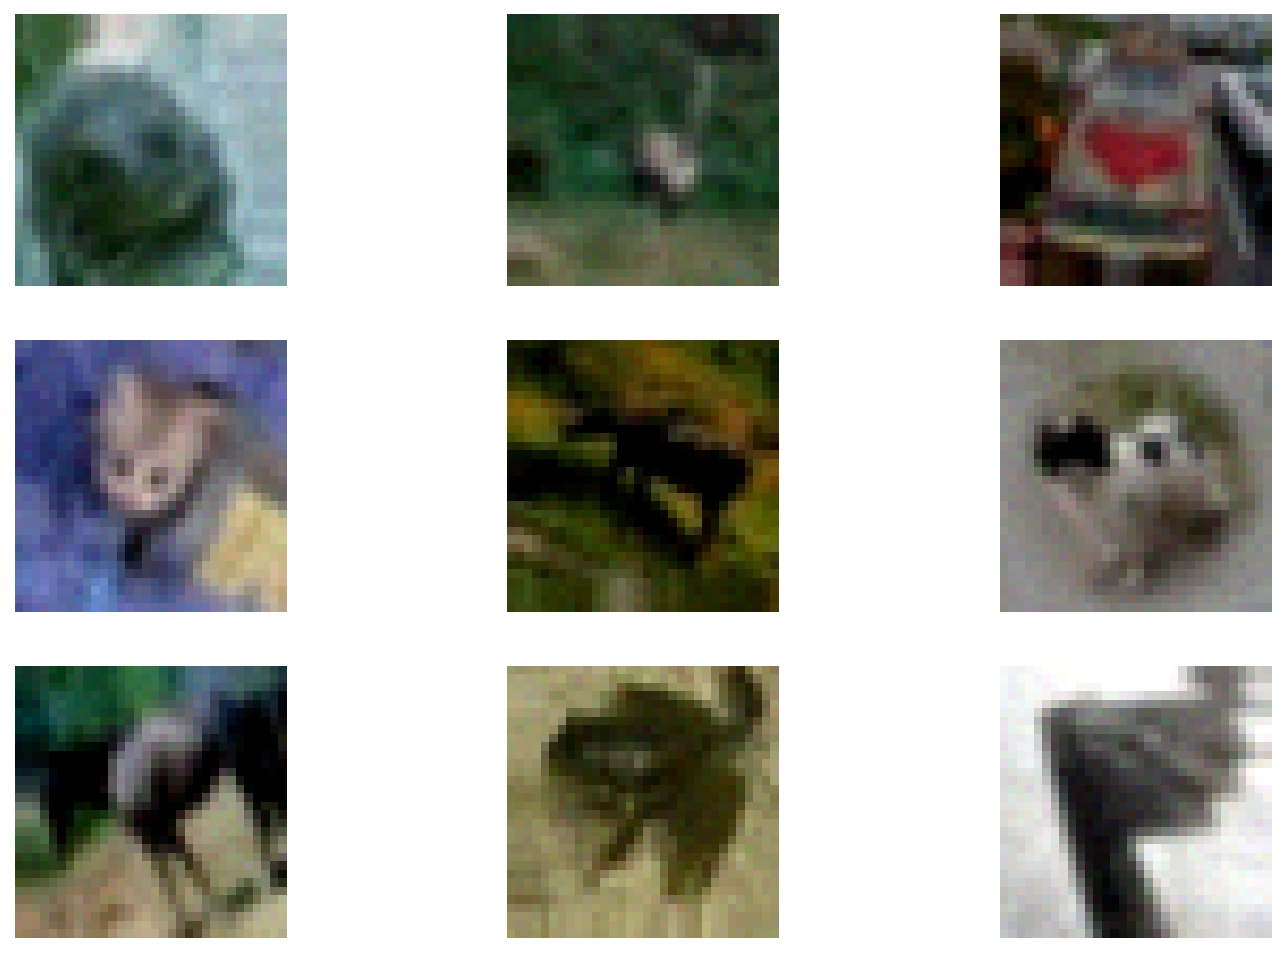

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

def grayScale(img):
    return tf.image.rgb_to_grayscale(img)

def save_image(img, img_name):
    tf.keras.utils.save_img(f"./train_new_ims/{img_name}", img)

def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    """Add Gaussian noise to an image."""
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    return noisy_image

def augment(image_array):
    out = tf.image.convert_image_dtype(image_array, dtype=tf.float32)

    # Random color jitter
    brightness_delta = tf.random.uniform([], -0.2, 0.1)
    contrast_factor = tf.random.uniform([], 0.9, 1.2)
    saturation_factor = tf.random.uniform([], 0.8, 1.2)
    hue_delta = tf.random.uniform([], -0.02, 0.02)
    out = tf.image.adjust_brightness(out, brightness_delta)
    out = tf.image.adjust_contrast(out, contrast_factor)
    out = tf.image.adjust_saturation(out, saturation_factor)
    out = tf.image.adjust_hue(out, hue_delta)

    # Position transforms
    rotate = tf.keras.layers.RandomRotation(0.08)
    shear = tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode='nearest')
    out = rotate(out)
    out = tf.image.flip_left_right(out)
    out = shear(out)

    # Add Gaussian noise
    out = add_gaussian_noise(out, mean=0.0, stddev=0.015)
    
    return out

def process_image(row):
    """Loads, augments, and saves the image based on the row data."""
    path = f"train_ims/{row['im_name']}"
    img = tf.keras.preprocessing.image.load_img(path)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    img_aug = augment(img_array)
    img_grayscale = grayScale(img_array)
    img_aug_grayscale = grayScale(img_aug)

    # Save images
    save_image(img_array, row['im_name'])
    save_image(img_grayscale, row['im_name'][:-4] + "_grayscale.jpg")
    save_image(img_aug, row['im_name'][:-4] + "_augmented.jpg")
    save_image(img_aug_grayscale, row['im_name'][:-4] + "_augmented_grayscale.jpg")

    return img_aug

def load_and_augment_images(path):
    df = pd.read_csv(path)
    first_batch_of_9 = []

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_image, row): row for index, row in df.iterrows()}

        for i, future in enumerate(as_completed(futures)):
            img_aug = future.result()
            if i < 9:
                first_batch_of_9.append(img_aug)
            print(f"Processed: {futures[future]['im_name']}")

    # Display the augmented images
    display_images(first_batch_of_9)

def display_images(images):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

load_and_augment_images('./train.csv')